#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchvision import datasets
from torchvision.transforms import ToTensor

# 모델 요약
from torchsummary import summary

In [ ]:
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='train_err', marker = '.')
    plt.plot(history.history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def set_seed(seed=10):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data=pd.read_csv(path+'data01_train.csv')
test_data=pd.read_csv(path+'data01_test.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_data.drop('subject',axis=1,inplace=True)
test_data.drop('subject',axis=1,inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
#전체 데이터의 상위 5개 행 확인
train_data.head()
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
train_data.describe()
test_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [ ]:
#전체 데이터의 모든 변수 확인
train_data.columns
test_data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# 데이터 분할을 합니다.
X = train_data.drop(columns=['Activity'])
y = train_data['Activity']

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 정수 인코딩 변환(LabelEncoder)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# 필요 시 원핫 인코딩
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_encoded)

# 기존 라벨 저장
#class_labels = le.classes_

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split

# 정수 인코딩 버전 사용 시
x_train, x_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [ ]:
from tensorflow.keras.optimizers import Adam
def plot_learning_curve(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def create_baseline_model(input_dim, output_dim, seed=10):
    set_seed(seed)
    model = Sequential([
        Dense(output_dim, activation='softmax', input_shape=(input_dim,))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model1 = create_baseline_model(x_train.shape[1], len(label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, verbose=0)

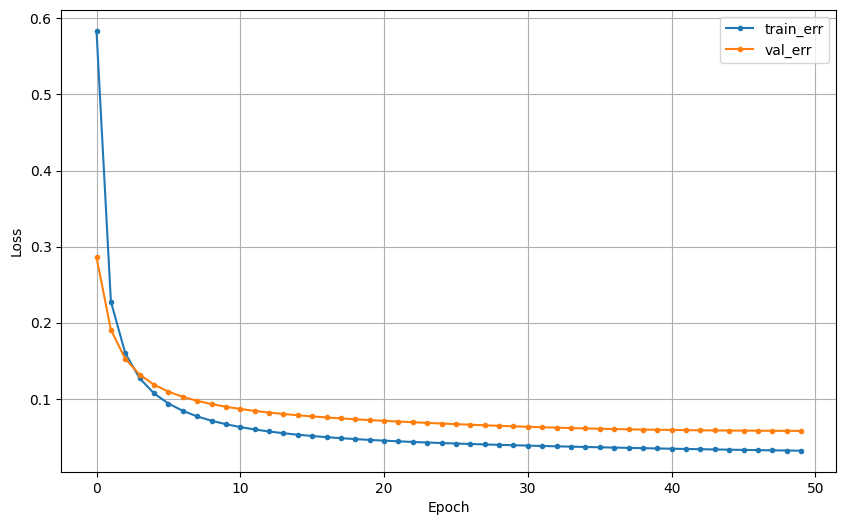

In [ ]:
# 학습곡선
dl_history_plot(history1)

In [ ]:
# 예측 및 평가
y_pred1 = model1.predict(x_val)
y_pred1_classes = np.argmax(y_pred1, axis=1)
accuracy1 = accuracy_score(y_val, y_pred1_classes)
print(f'Model 3 Accuracy: {accuracy1:.4f}')


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 3 Accuracy: 0.9805


In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [ ]:
# 모델 설계
def create_complex_model2(input_dim, output_dim, seed=10):
    set_seed(seed)
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# 컴파일 및 학습
model2 = create_complex_model2(x_train.shape[1], len(label_encoder.classes_))

# 학습 (모델2)
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


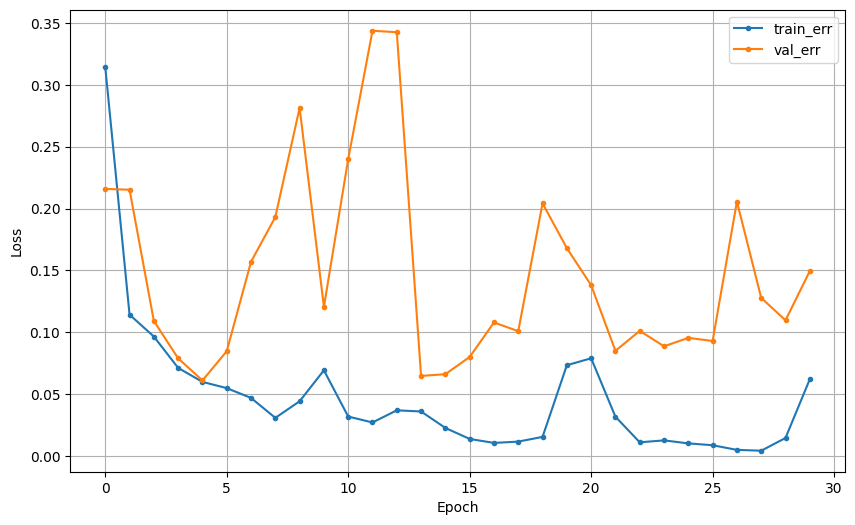

In [ ]:
# 학습곡선
dl_history_plot(history2)

In [ ]:
# 예측 및 평가
y_pred2 = model2.predict(x_val)
y_pred2_classes = np.argmax(y_pred2, axis=1)
accuracy2 = accuracy_score(y_val, y_pred2_classes)
print(f'Model 3 Accuracy: {accuracy2:.4f}')


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model 3 Accuracy: 0.9728


### (3) 모델3 : 학습률, epoch 등 조정

In [ ]:
# 모델 설계
def create_tuned_model3(input_dim, output_dim, learning_rate=0.0001, seed=10):
    set_seed(seed)
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# 컴파일 및 학습
model3 = create_tuned_model3(x_train.shape[1], len(label_encoder.classes_))

# 학습 (모델3)
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


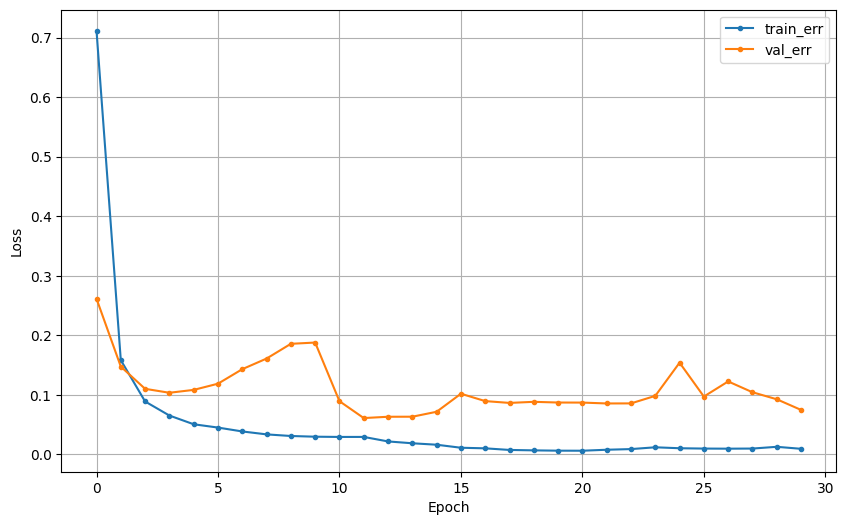

In [ ]:
# 학습곡선
dl_history_plot(history3)

In [ ]:
# 예측 및 평가
y_pred3 = model3.predict(x_val)
y_pred3_classes = np.argmax(y_pred3, axis=1)
accuracy3 = accuracy_score(y_val, y_pred3_classes)
print(f'Model 3 Accuracy: {accuracy3:.4f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 3 Accuracy: 0.9839


### (4) 모델4 :  학습률, epoch 등 조정

In [ ]:
# 모델 설계
def create_epoch_tuned_model(input_dim, output_dim, learning_rate=0.0001, seed=10):
    set_seed(seed)
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# 컴파일 및 학습
model4 = create_epoch_tuned_model(x_train.shape[1], len(label_encoder.classes_))

es_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# 학습 (모델4 - 100 에폭)
history4 = model4.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100,callbacks=[es_callback],verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


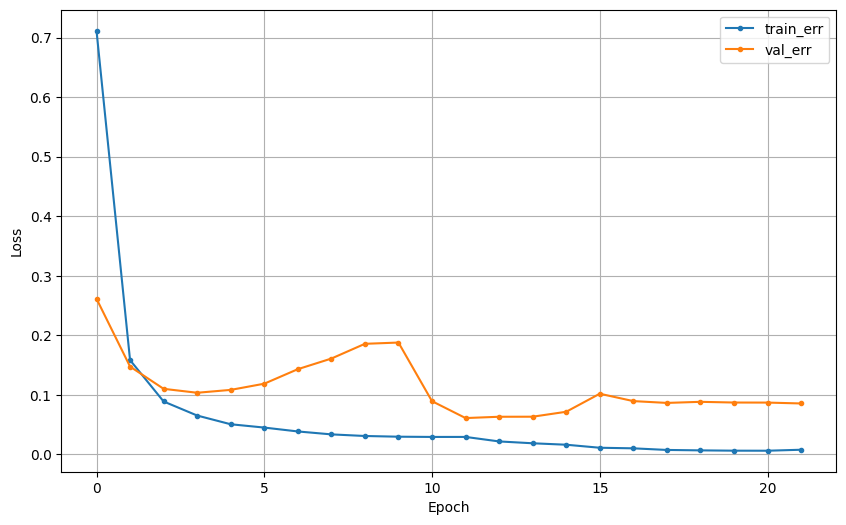

In [ ]:
# 학습곡선
dl_history_plot(history4)

In [ ]:
# 예측 및 평가
y_pred4 = model4.predict(x_val)
y_pred4_classes = np.argmax(y_pred4, axis=1)
accuracy4 = accuracy_score(y_val, y_pred4_classes)
print(f'Model 4 Accuracy: {accuracy4:.4f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model 4 Accuracy: 0.9822


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기(test)

# subject 삭제

# x, y 분할
x_test = test_data.drop(columns='Activity')  # 특징(feature)들
y_test = test_data['Activity']  # 타겟 변수 (예: 6개의 클래스 중 하나)
# x : 스케일링 적용
x_test_scaled = scaler.transform(x_test)  # scaler는 train에서 학습한 StandardScaler

# y : 정수인코딩 적용
y_test_encoded = label_encoder.transform(y_test)  # label_encoder는 train에서 학습한 LabelEncoder


In [ ]:
# test 데이터에 대한 성능 측정
# 모델 1~3 예측
y_test_pred1 = model1.predict(x_test_scaled)
y_test_pred2 = model2.predict(x_test_scaled)
y_test_pred3 = model3.predict(x_test_scaled)
y_test_pred4 = model4.predict(x_test_scaled)

# 클래스 인덱스로 변환
y_test_pred1_cls = np.argmax(y_test_pred1, axis=1)
y_test_pred2_cls = np.argmax(y_test_pred2, axis=1)
y_test_pred3_cls = np.argmax(y_test_pred3, axis=1)
y_test_pred4_cls = np.argmax(y_test_pred4, axis=1)

# 정확도 계산
acc1 = accuracy_score(y_test_encoded, y_test_pred1_cls)
acc2 = accuracy_score(y_test_encoded, y_test_pred2_cls)
acc3 = accuracy_score(y_test_encoded, y_test_pred3_cls)
acc4 = accuracy_score(y_test_encoded, y_test_pred4_cls)

# 결과 출력
print(f"Model 1 (Baseline)  Test Accuracy: {acc1:.4f}")
print(f"Model 2 (Complex)   Test Accuracy: {acc2:.4f}")
print(f"Model 3 (Tuned)     Test Accuracy: {acc3:.4f}")
print(f"Model 4 (Regularized) Test Accuracy: {acc4:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model 1 (Baseline)  Test Accuracy: 0.9769
Model 2 (Complex)   Test Accuracy: 0.9680
Model 3 (Tuned)     Test Accuracy: 0.9789
Model 4 (Regularized) Test Accuracy: 0.9762


#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.